# Week 05 Exercises

More advanced network measures with visualization and qualitative analysis of teh house of representatives network. 
Properties of the network structure, including how parties and states shape the network

In [283]:
import networkx as nx
from networkx import DiGraph
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
plt.style.use('seaborn-deep')

import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import re
import os
import json
import operator
import collections
import math
import random

data_path = '../data'

Loading the the data about each of the congresses into pandas

In [4]:
files = {x: os.path.join(data_path, 'H' + str(x) + '.csv') for x in [113, 114, 115]}

dfs = {congress: pd.read_csv(f) for congress, f in files.items()}
for congress, df in dfs.items():
    dfs[congress]['congress_number'] = congress
    dfs[congress].set_index('WikiPageName')

df_concat = pd.concat(dfs).reset_index(drop=True)

print('Coloums in the dataset:', list(df))

Coloums in the dataset: ['WikiPageName', 'Party', 'State', 'congress_number']


## Exercise 1

Generate a directed graph to store the network for one of the houses of representatives.

### Helper functions

First lets define the helper functions to read in the data and create the graph

In [5]:
def getFileContent(name: str, congress_number: int):
    '''Reading the file content for a congress member
    
    @param name: Name of the congress member
    @param congress_number: The number of congress to look in
    '''
    with open(os.path.join('../data', str(congress_number), str(name)), 'r') as f:
        content = json.load(f)
        
    return content['revisions'][0]['*']

In [6]:
def isCongressMember(name: str, members):
    '''Check in the name is a congress member
    
    @param name: Name of a potential congress member
    @param members: Known members of the congress
    '''
    name = re.sub(r'\ ', '_', name)
    return name in members

In [7]:
def findLinks(content: str):
    '''Find links in a text 
    
    @param content: The text to search for links in
    '''
    for link in re.findall(r'\[\[(.*?)\]\]', content):
        yield re.sub('\|.*', '', link)

In [8]:
def getCongressConnections(name: str, congress_number: int, members):
    '''Get all the connections for a given congress member
    
    @param name: Name of the congress member
    @param congress_number: The number of the congress to look at
    '''
    content = getFileContent(re.sub('_', ' ', name), congress_number)
    links = findLinks(content)
    for x in links:
        if isCongressMember(x, members):
            yield x

In [9]:
def getEdges(congress_number: int):
    '''Get all the edges in a given congress
    
    @param congress_number: The number of the congress to get the edges for
    '''
    members = dfs[congress_number].groupby('WikiPageName')['WikiPageName'].groups
    for member in members:
        cleaned_member = re.sub(r'_', ' ', member)
        for connection in getCongressConnections(member, congress_number, members):
            yield cleaned_member, connection

In [10]:
def getNodes(congress_number: int):
    '''Get all the nodes for a given congress with their state and party as attribute
    
    @param congress_number: The number of the congress
    '''
    df = dfs[congress_number]
    members = df.groupby('WikiPageName')['WikiPageName'].groups
    
    for member in members:
        row = df.loc[df['WikiPageName'] == member].reset_index()
        
        party = str(row.at[0, 'Party'])
        if party == 'Republican': color ='red' 
        else: color = 'blue'
        attributes = {
            'state': row.at[0, 'State'],
            'party': party,
            'node_color': color
        }
        member = re.sub(r'_', ' ', member)

        yield (member, attributes)

### Generating the graph

Using the helper functions above to read in the data, parse it and get all the connections within.

In [12]:
congress = 113
connections = list(getEdges(congress))
nodes = list(getNodes(congress))

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(connections)

## Exercise 2 - Visualizing the graph

Drawing using the networkx spring layout

In [13]:
options = {
    'width': 0.2,
    'alpha': 0.9,
}

node_color = [attr['node_color'] for _, attr in nodes]
node_size = [G.degree(n) * 10 for n, _ in nodes]

In [14]:
pos = nx.spring_layout(G, k=0.15, iterations=2)

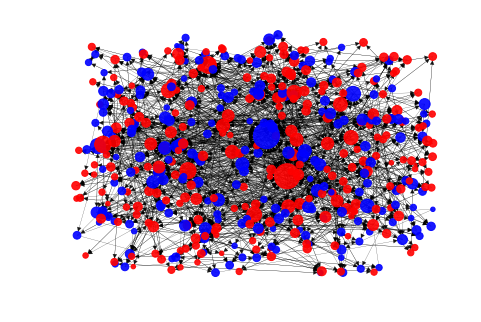

In [15]:
nx.draw(G, pos, node_size=node_size, node_color=node_color, **options)

While this does not look perfect, but it does show at least some of the structure in the network.

## Exercise 3 - Reasons for links

When looking at the graph, it seems that the number of connections to people in your own party and the oponent party is quite similar.
By analysing the wikipedia page for Nancy Pelosi, whom is the node with the largest out degree, she seems to be connected to many people from her own state, favoring those from here own party.
However, there is also several parts that talks about her elections, which meansions her opponents in these, hence giving a reason to link to people from the other party.

## Exercise 4 - Begin to analyze the network of the house of representatives

As relationships can be directional the network is also build by using a directed graph. 
As one person could have had a influence on other, which would mean this one-way relationship.
An example of this is an election. The losing side might write about who they where figthing against and why the lost, while the winning side might have moved on other more important elections, hense having no reason to mention their early elections.

In [110]:
N = len(G.nodes())
E = len(G.edges())
density = E / (N * (N - 1) / 2)
print('Total number of nodes in the network:'.ljust(40), N)
print('Total number of links in the network:'.ljust(40), E)
print('Network density:'.ljust(40), '{0:.2%}'.format(density))

Total number of nodes in the network:    444
Total number of links in the network:    1606
Network density:                         1.63%


In [17]:
out_degrees = list(dict(G.out_degree()).values())
in_degrees = list(dict(G.in_degree()).values())

def printDegreeStatistics(degrees):
    just = 10
    print('Average:'.ljust(just), '%.2f' % np.average(degrees))
    print('Median:'.ljust(just), '%d' % np.median(degrees))
    print('Mode:'.ljust(just), stats.mode(degrees)[0][0])
    print('Minimum:'.ljust(just), min(degrees))
    print('Maximum:'.ljust(just), max(degrees))

#### Out degree statistics

In [18]:
printDegreeStatistics(out_degrees)

Average:   3.62
Median:    3
Mode:      3
Minimum:   0
Maximum:   20


#### In degree statistics

In [19]:
printDegreeStatistics(in_degrees)

Average:   3.62
Median:    3
Mode:      2
Minimum:   0
Maximum:   57


The average of the in- and out-degrees is exactly the same, which must be the case as every outgoing edge must be an ingoing node elsewhere.
The median and mode in both cases shows that it is most common to be connected only to a few people.
One interesting thing to note is that the maximum value for the in-degrees are much higher than the maximum value for the out-degrees. 
This seems right, as many people would link to a popular person, making them even more popular.

#### Top five politicians by in- and out-degrees

What is their party and state?
Do these politicians play a particular role in the house?

In [20]:
def sortDegree(degrees):
    return sorted(dict(degrees).items(), key=operator.itemgetter(1), reverse=True)

def printTopFive(degrees):
    for member, degree in sortDegree(degrees)[:5]:
        node = G.node[member]
        print(member.ljust(40), 'Degree:', str(degree).ljust(10),
              'Party:', node['party'],
              'State:'.rjust(20), node['state'])
        
print('Top five by out-degree:')
printTopFive(G.out_degree())

print('\nTop five by in-digree:')
printTopFive(G.in_degree())


Top five by out-degree:
Michele Bachmann                         Degree: 20         Party: Republican               State: Minnesota
Devin Nunes                              Degree: 15         Party: Republican               State: California
Tom Rooney (Florida politician)          Degree: 14         Party: Republican               State: Florida
Keith Ellison                            Degree: 13         Party: Democratic               State: Minnesota
Bill Posey                               Degree: 12         Party: Republican               State: Florida

Top five by in-digree:
Nancy Pelosi                             Degree: 57         Party: Democratic               State: California
John Boehner                             Degree: 54         Party: Republican               State: Ohio
Eric Cantor                              Degree: 23         Party: Republican               State: Virginia
Paul Ryan                                Degree: 23         Party: Republican           

Some of these people seem to hold special positions, such as Devin Nunes whom is chair of intelligence, and Nancy Pelosi whom is the minority leader.

#### Plot he distribution of in- and out-degrees

What is the most common in- and out-degree? 
(The mode was calculated above to be 2 and 3 respectively)

Also plot the propability degree distribution on a log-log scale.

In [21]:
def calculateNormalizedDistribution(data):
    '''Calculate the distribution of the data and normalize it
    
    @param data: An array of data
    @returns: The distribution of the data as a dictionary, normalized
    '''
    hist = dict(collections.Counter(data))
    return dict(map(lambda x: (int(x[0]), x[1] / len(data)), hist.items()))

In [22]:
def plotDegreeDistribution(degrees, title):
    '''Plot the degree distribution of the data
    
    The data is plotted in both linear and log-log scale.
    
    @param degrees: The degrees to plot
    @param title: Title of the plot
    '''
    fig, ax = plt.subplots(2, 1, figsize=(15, 8))
    
    degrees = calculateNormalizedDistribution(degrees)
    fig.suptitle(title, fontsize=20)
    
    ax[0].set_ylabel('$p_k$')
    ax[0].scatter(degrees.keys(), degrees.values(),  marker='o')
    
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    ax[1].set_xlabel('k')
    ax[1].set_ylabel('$p_k$')
    ax[1].scatter(degrees.keys(), degrees.values(), marker='o')
    
    plt.show()

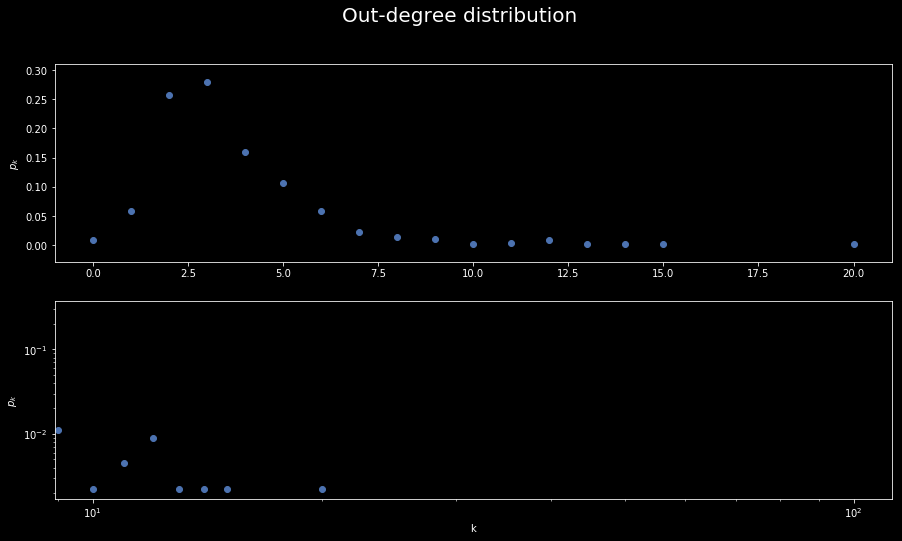

In [30]:
plotDegreeDistribution(out_degrees, 'Out-degree distribution')

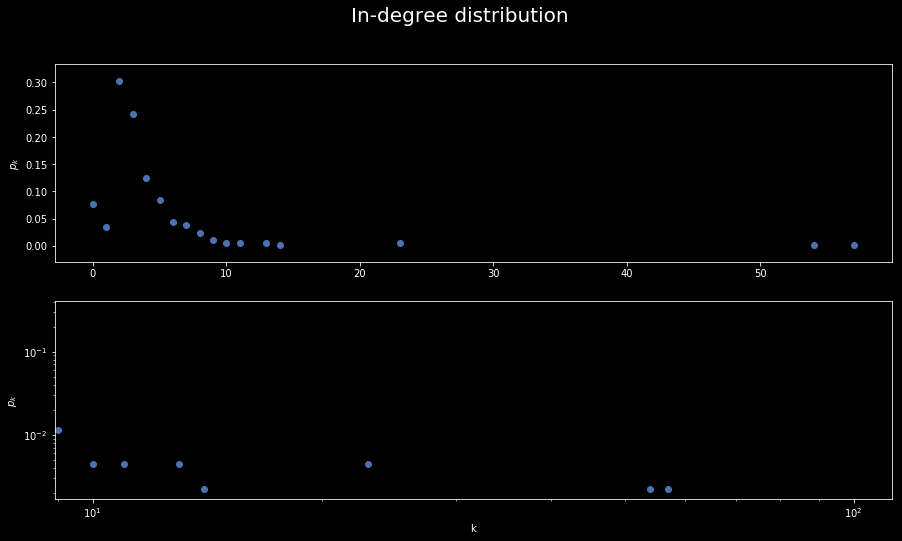

In [31]:
plotDegreeDistribution(in_degrees, 'In-degree distribution')

The distribution does diffenently not seem to follow a powerlaw distribution when analysing the log-log plots, althought there might be too little data to conclude this.
The distributions does not follow a Poisson distribution either.
Overall they look more like something in between these two things.

#### Scatter plot of the in- versus out-degree for all politicians

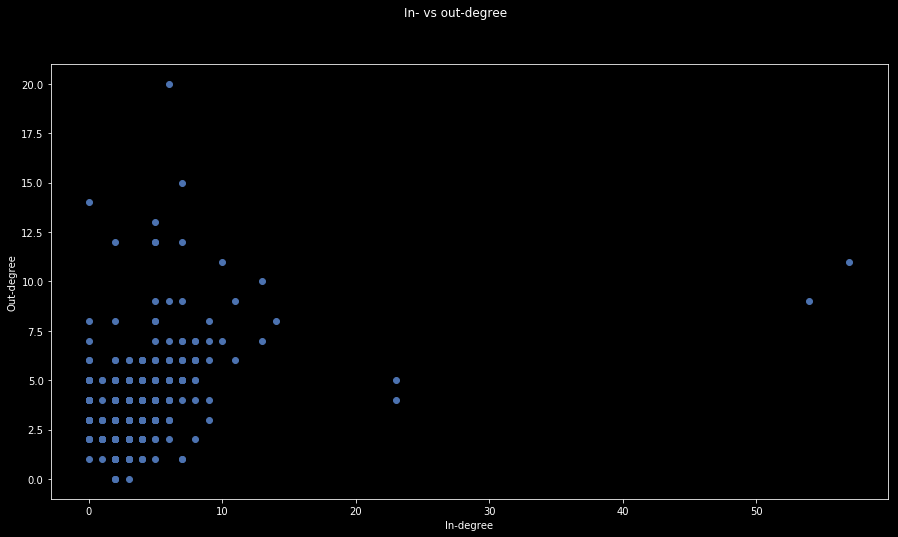

In [32]:
degrees = [(G.in_degree(n), G.out_degree(n)) for n in G.nodes()]
in_degrees, out_degrees = zip(*degrees)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
fig.suptitle('In- vs out-degree')
ax.set_xlabel('In-degree')
ax.set_ylabel('Out-degree')
ax.scatter(in_degrees, out_degrees)
plt.show()

Most of the politicians have a linear relationship between their in- and out-degree, with only a few outliers having a very high in-degree or out-degree.
There is also a few with zero in-degree that still have quite a few outgoing edges.

#### Heatmap of the in- vs out-degree

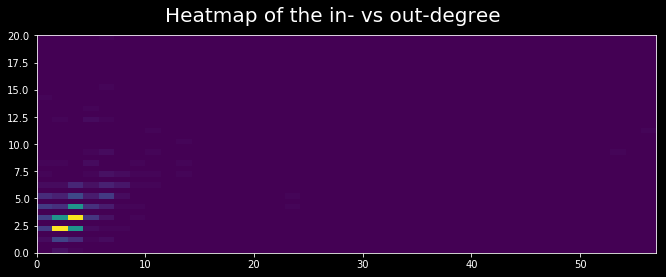

In [88]:
heatmap, xedges, yedges = np.histogram2d(in_degrees, out_degrees, bins=40)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
fig.suptitle('Heatmap of the in- vs out-degree', fontsize=20)
ax.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

In the heatmap, it is clear to see that all the activity is focused around the 

## Exercise 5 - Going in depth with the structure of the house of representatives network

First test if the graph is weakly connected

In [37]:
nx.is_weakly_connected(G)

True

Creating the undirected version of the graph

In [39]:
UG = G.to_undirected()

In [68]:
def displayTopFiveCentralPoliticians(nodes: dict):
    '''Display the top five nodes ranked by some score
    
    @param nodes: A dictonary with nodes as keys and a score as the value
    '''
    top_five = sorted(nodes.items(), key=operator.itemgetter(1), reverse=True)[:5]
    for member, score in top_five:
        print(member.ljust(40), score)

#### Find the 5 most central politicians according to [betweenness centrality](https://networkx.github.io/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html).

In [66]:
betweenness_nodes = nx.betweenness_centrality(G)
displayTopFiveCentralPoliticians(betweenness_nodes)

Nancy Pelosi                             0.19277674315786733
John Boehner                             0.16615800379997106
Justin Amash                             0.07472746802454165
Kevin McCarthy (California politician)   0.0634689147875171
Henry Waxman                             0.05483547127400424


These people must be connected with a lot of people, and for these people that do not know each other, the best way to contact someone would be through these *hub* people.

#### Find the 5 most central politicians according to [eigenvector centrality](https://networkx.github.io/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.centrality.eigenvector_centrality.html). Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). 

In [71]:
print('Eigenvector centrality based on the in-degree')
displayTopFiveCentralPoliticians(nx.eigenvector_centrality(G))

print('\nEigenvector centrality based on the out-degree')
displayTopFiveCentralPoliticians(nx.eigenvector_centrality(G.reverse()))

Eigenvector centrality based on the in-degree
Nancy Pelosi                             0.47876872740105547
John Boehner                             0.3851124992629899
Steny Hoyer                              0.29856201145529426
John Dingell                             0.27165394335279297
Eric Cantor                              0.1918589637569781

Eigenvector centrality based on the out-degree
Michele Bachmann                         0.22528007772098962
Kevin McCarthy (California politician)   0.21294604682146617
Devin Nunes                              0.19894855367987982
Keith Ellison                            0.184887443929822
Brad Sherman                             0.1735837620687191


The centrality is calculated regarding both the in- and out-degrees.
Interestingly, it can be seen that the top five is completely different between the two.

#### Plot the betweenness centrality of nodes vs their degree centrality. Is there a correlation between the two? Did you expect that? Why?

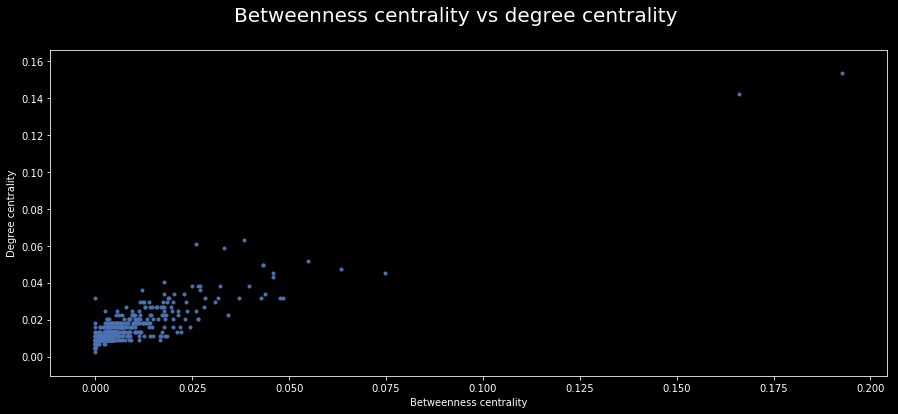

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
fig.suptitle('Betweenness centrality vs degree centrality', fontsize=20)

degree_nodes = nx.degree_centrality(G)
xs, ys = zip(*[(dict(betweenness_nodes)[member], degree) for member, degree in degree_nodes.items()])

ax.set_xlabel('Betweenness centrality')
ax.set_ylabel('Degree centrality')
ax.scatter(xs, ys, marker='.')
plt.show()

A relative linear relationship between the betweenness and degree centrality exists.
As a node with high degree is likely be on the path connecting two less connected nodes, this linear relathionship is expected.

#### Repeat the two points above using eigenvector centrality instead. Do you observe any difference? Why?

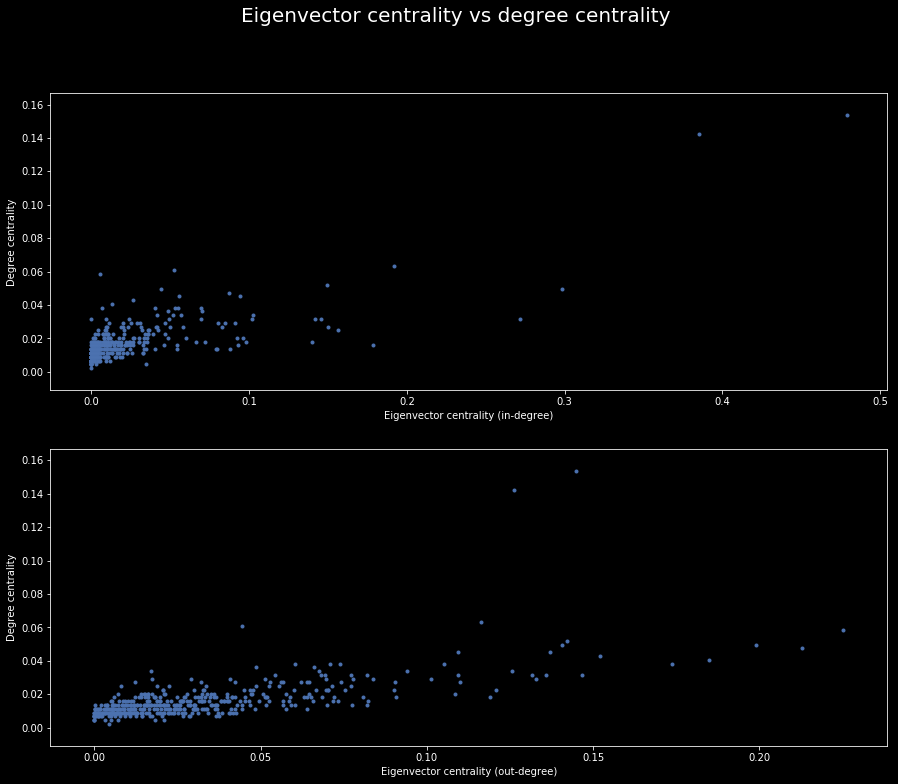

In [94]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
fig.suptitle('Eigenvector centrality vs degree centrality', fontsize=20)

degree_nodes = nx.degree_centrality(G)
eigenvector_nodes_in = dict(nx.eigenvector_centrality(G))
xs, ys = zip(*[(eigenvector_nodes_in[member], degree) for member, degree in degree_nodes.items()])

eigenvector_nodes_out = dict(nx.eigenvector_centrality(G.reverse()))
xs_out, ys_out = zip(*[(eigenvector_nodes_out[member], degree) for member, degree in degree_nodes.items()])

ax[0].set_xlabel('Eigenvector centrality (in-degree)')
ax[0].set_ylabel('Degree centrality')
ax[0].scatter(xs, ys, marker='.')

ax[1].set_xlabel('Eigenvector centrality (out-degree)')
ax[1].set_ylabel('Degree centrality')
ax[1].scatter(xs_out, ys_out, marker='.')
plt.show()

With respect to the in-degree, the relationship looks similar to the relationship between the betweennness and degree centrality.

For the out-degree, there is still a linear relationship, however the eigenvector centrality increases much faster than the decree centrality.

#### Is the _undirected version_ of the graph [assortative with respect do degree](https://networkx.github.io/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html#networkx.algorithms.assortativity.degree_assortativity_coefficient)? (e.g. do high-degree politicians tend to link to other high-degree politicians, and low-degree politicians to other low-degree politicians?). Provide an interpretation of your answer. 

In [99]:
print('Degree assortativity coefficient:', nx.degree_assortativity_coefficient(G))

Degree assortativity coefficient: 0.10355205421285262


As the degree assortativity coefficent is normalized, this value is quite low.
This means that politicians does not tend to only link to other people with a similar degree. 

#### What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes $N$ and probablity of connection $p$?

In [103]:
d_mean = nx.average_shortest_path_length(G)
print('Average shorest path:', d_mean)

Average shorest path: 4.815681369857442


The network density ($p$) has much earlier been caculated to around 1%

In [112]:
print('Network density (p): {0:.2%}'.format(density))

Network density (p): 1.63%


To compare the average shortest path length to a random graph, lets create one

In [121]:
BA = nx.barabasi_albert_graph(N, math.floor(E / N))
print('Average sortest path in Barabasi-Albert graph: {0:.2f}'.format(nx.average_shortest_path_length(BA)))

Average sortest path in Barabasi-Albert graph: 3.21


As it can be seen here, the shortest path is a bit shorter in the random graph, which points to some structure in how the politicians are connected to each other. 
This is also what one would expect from a network of people.
By analysing the politicians wikipedia pages and who they are connected to, a relationship between their connections and where they are from, as well as their party, is clear.

## Exercise 6 - Parties and nodes centrality

#### Compute the average node centrality for Democratic and Republican members of the house.

In [173]:
def calculateAverageNodeCentrality(G):
    nodes_dem = [node for node, attr in G.nodes(data=True) if attr['party'] == 'Democratic']
    nodes_rep = [node for node, attr in G.nodes(data=True) if attr['party'] == 'Republican']

    degree_centrality = nx.degree_centrality(G)
    average_dem = sum(map(lambda name: degree_centrality[name], nodes_dem)) / len(nodes_dem)
    average_rep = sum(map(lambda name: degree_centrality[name], nodes_rep)) / len(nodes_rep)

    return average_dem, average_rep

In [174]:
average_dem, average_rep = calculateAverageNodeCentrality(G)
print('Average degree centrality for Demotratic: {0:.5f}'.format(average_dem))
print('Average degree centrality for Republican: {0:.5f}'.format(average_rep))

Average degree centrality for Demotratic: 0.01661
Average degree centrality for Republican: 0.01609


It can be seen that the average degree centrality is almost the same for the Republicans and the Democrats

#### Create a new graph, with the same nodes and edges, but where the association between nodes and parties is shuffled. Compute the average centrality of Republicans and Democrats nodes for this *randomized* graph.

Creating the graph with the party randomly assigned.

In [311]:
def generateFromGraphWithRandomParty(G):
    '''Generate the same graph with the parties randomly assigned to each node
    
    @param G: The graph with all the nodes and edges    
    '''
    RG = nx.DiGraph()
    RG_nodes = [(node, { 'party': random.choice(['Democratic', 'Republican']) }) for node in G.nodes()]
    RG.add_nodes_from(RG_nodes)
    RG.add_edges_from(G.edges())
    
    return RG

Now recalculating the evareg node centrality for the two parties in the new graph.

In [312]:
RG = generateFromGraphWithRandomParty(G)
average_dem, average_rep = calculateAverageNodeCentrality(RG)

print('Average degree centrality for Demotratic: {0:.5f}'.format(average_dem))
print('Average degree centrality for Republican: {0:.5f}'.format(average_rep))

Average degree centrality for Demotratic: 0.01567
Average degree centrality for Republican: 0.01693


It can be seen, that the value stays almost the same.

In [307]:
number_of_graphs = 1000
average_cent = [calculateAverageNodeCentrality(generateFromGraphWithRandomParty(G)) 
                for _ in range(number_of_graphs)]

In [195]:
def plotHistogram(data, ax):
    hist, bins = np.histogram(data, bins=10)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    
    ax.bar(center, hist, align='center', width=width)

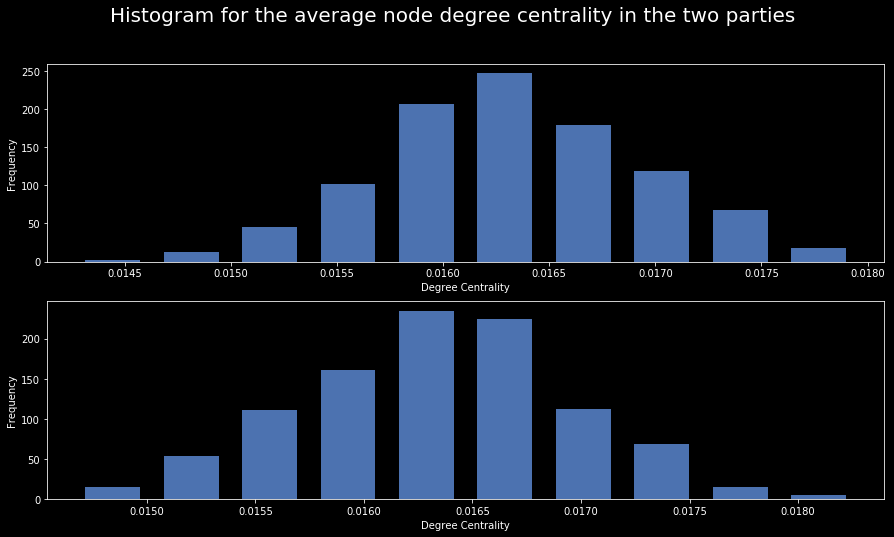

In [205]:
fig, ax = plt.subplots(2, 1, figsize=(15,8))

fig.suptitle('Histogram for the average node degree centrality in the two parties', fontsize=20)

for a in ax:
    a.set_ylabel('Frequency')
    a.set_xlabel('Degree Centrality')

average_dem, average_rep = zip(*average_cent)
plotHistogram(average_dem, ax[0])
plotHistogram(average_rep, ax[1])

Compared to the non-randomized graph, the degree centrality seem to be in the same region.
This must mean that the politicians are connection to each other quite independent of which party they belong to.

## Exercise 7 - Assortativity with respect to parties and states

In [290]:
def neighborsWithSameAttribute(member: str, attribute: str, G: DiGraph):
    '''Find all the neighbors that are in the same party
    
    @param member: Name of the node to analyse
    @param G: The graph to look in
    @returns: The list of all neighbors that are in the same party
    '''
    for neighbor in G.neighbors(member):
        if G.node[neighbor][attribute] == G.node[member][attribute]:
            yield neighbor

In [291]:
def neighborsWithSameAttributeFrequency(member: str, attribute: str, G: DiGraph):
    '''The frequency of the members connections that are in the same party
        
    @param member: The member to analyze
    @param G: The graph to look in
    @returns: The fraction of members in the same party as the member
    '''
    if len(list(G.neighbors(member))) != 0:
        return len(list(neighborsInSameParty(member, G))) / len(list(G.neighbors(member)))

In [298]:
def averageNumberOfNeighborsWithSameAttribute(G: DiGraph, attribute: str):
    same_party_frequencies = [
        x for x in 
            [neighborsWithSameAttributeFrequency(member, attribute, G) for member in G.nodes()] 
        if x is not None
    ]
    return np.average(same_party_frequencies)

In [299]:
print('Average number of neighbors in the same party: {0:.4f}'
      .format(averageNumberOfNeighborsWithSameAttribute(G, 'party')))

Average number of neighbors in the same party: 0.6309


Here it can be seen that most members of congress is, on average, connected to more people in their own party, however, only by a small difference.
The difference is much smaller than what I would have expected.

#### Create a new graph, with the same nodes and edges, but where the association between nodes and parties is shuffled. Compute the measure above for this *randomized* graph

In [301]:
RG = generateFromGraphWithRandomParty(G)
print('Average number of neighbors in the same party: {0:.4f}'
      .format(averageNumberOfNeighborsWithSameAttribute(RG, 'party')))

Average number of neighbors in the same party: 0.4879


In this *random* graph it can be seen that each member is connected to just as many Democrats as Republicans.

#### Repeat the point above 100 times (at least). Plot the distribution of the values obtained and compare it with the value you have found for the real graph. Do you find that the chance to connect to a member of the same party is higher than it would be by random chance?

In [303]:
number_of_graphs = 1000
same_party = [averageNumberOfNeighborsWithSameAttribute(generateFromGraphWithRandomParty(G), 'party') 
              for _ in range(number_of_graphs)]

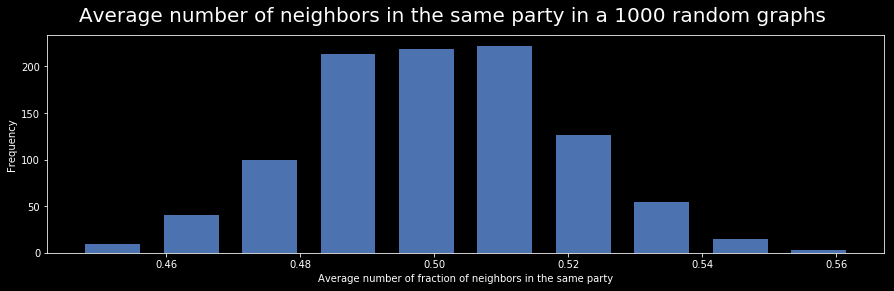

In [310]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

fig.suptitle('Average number of neighbors in the same party in a {0} random graphs'.format(number_of_graphs),
             fontsize=20)
ax.set_xlabel('Average number of fraction of neighbors in the same party')
ax.set_ylabel('Frequency')
plotHistogram(same_party, ax)
plt.show()

#### Could you get to the same conclusion by measuring the [assortativity coefficient with respect to the party?](https://networkx.github.io/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html#networkx.algorithms.assortativity.attribute_assortativity_coefficient)

In [278]:
print(nx.attribute_assortativity_coefficient(G, 'party'))

0.28336513227060006


This seem to conclude that the politicians are much more connected to members of the opposite party, hence not what we concluded above.

#### Repeat the exercise, but considering states insteaf of parties

First lets look at the average frequency of neighbors in the same state for the actual graph.

In [304]:
print('Average number of neighbors in the same party: {0:.4f}'
      .format(averageNumberOfNeighborsWithSameAttribute(G, 'state')))

Average number of neighbors in the same party: 0.6309


This again shows that the politicians are more likely to be connected to people from their own state.

Lets generate some random graphs and recalculate.

In [314]:
def generateFromGraphWithRandomState(G: DiGraph, states: list):
    '''Generate the same graph with the parties randomly assigned to each node
    
    @param G: The graph with all the nodes and edges    
    '''
    RG = nx.DiGraph()
    RG_nodes = [(node, { 'party': random.choice(states) }) for node in G.nodes()]
    RG.add_nodes_from(RG_nodes)
    RG.add_edges_from(G.edges())
    
    return RG

In [318]:
states = list(set(nx.get_node_attributes(G, 'state').values()))
same_state = [averageNumberOfNeighborsWithSameAttribute(generateFromGraphWithRandomState(G, states), 'state') 
              for _ in range(number_of_graphs)]

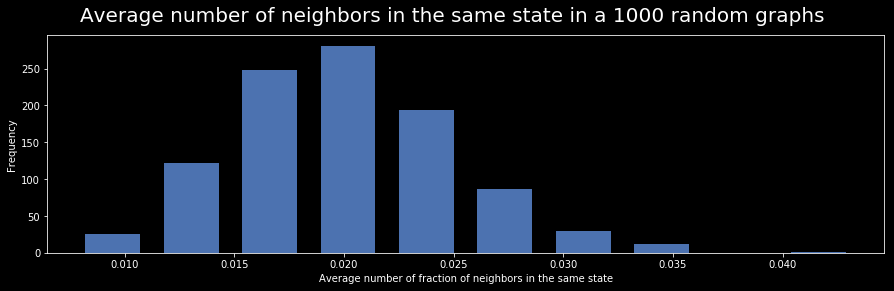

In [319]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

fig.suptitle('Average number of neighbors in the same state in a {0} random graphs'.format(number_of_graphs),
             fontsize=20)
ax.set_xlabel('Average number of fraction of neighbors in the same state')
ax.set_ylabel('Frequency')
plotHistogram(same_state, ax)
plt.show()

Again can it be seen that the random graphs all lie way lower than before, which is also expected as there are more states than parties.
From this data it is even more clean that in the original graph, the politicians clearly favors connecting to other politicians from the same state as themselves.

#### How do you interpret these results in light of what you have observed in Exercise 3?